In [1]:
import os
import sys
import polars as pl
import polars.selectors as cs

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY, PROCESSED_PICARRO_DATA_DIRECTORY, POSTPROCESSED_DATA_DIRECTORY
from utils.import_data import import_acropolis_system_data
from utils.plot_dataframes import plot_column, plot_column_difference

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))
assert(os.path.exists(PROCESSED_PICARRO_DATA_DIRECTORY))

In [2]:
side_by_side_times = {
    1: {"start_time": datetime(2024, 2, 7, 0, 0, 0), "end_time": datetime(2024, 2, 26, 23, 59, 59)},
    2: {"start_time": datetime(2024, 3, 13, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    3: {"start_time": datetime(2024, 1, 13, 0, 0, 0), "end_time": datetime(2024, 2, 18, 23, 59, 59)},
    4: {"start_time": datetime(2024, 2, 14, 0, 0, 0), "end_time": datetime(2024, 3, 20, 0, 0, 0)},
    5: {"start_time": datetime(2024, 2, 7, 0, 0, 0), "end_time": datetime(2024, 2, 25, 23, 59, 59)},
    6: {"start_time": datetime(2024, 2, 20, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    7: {"start_time": datetime(2024, 2, 21, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    8: {"start_time": datetime(2024, 2, 13, 0, 0, 0), "end_time": datetime(2024, 3, 11, 23, 59, 59)},
    9: {"start_time": datetime(2024, 2, 12, 0, 0, 0), "end_time": datetime(2024, 4, 5, 9, 59, 59)},
    10: {"start_time": datetime(2024, 1, 13, 0, 0, 0), "end_time": datetime(2024, 4, 7, 23, 59, 59)},
    11: {"start_time": datetime(2024, 1, 12, 0, 0, 0), "end_time": datetime(2024, 4, 7, 23, 59, 59)},
    12: {"start_time": datetime(2023, 12, 23, 0, 0, 0), "end_time": datetime(2024, 2, 11, 23, 59, 59)},
    13: {"start_time": datetime(2024, 1, 13, 0, 0, 0), "end_time": datetime(2024, 1, 30, 23, 59, 59)},
    14: {"start_time": datetime(2024, 3, 3, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    15: {"start_time": datetime(2024, 2, 26, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    16: {"start_time": datetime(2023, 12, 23, 0, 0, 0), "end_time": datetime(2024, 2, 5, 23, 59, 59)},
    17: {"start_time": datetime(2024, 3, 28, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    18: {"start_time": datetime(2023, 12, 23, 0, 0, 0), "end_time": datetime(2024, 2, 5, 23, 59, 59)},
    19: {"start_time": datetime(2024, 3, 24, 0, 0, 0), "end_time": datetime(2024, 4, 17, 9, 59, 59)},
    20: {"start_time": datetime(2023, 12, 23, 0, 0, 0), "end_time": datetime(2024, 2, 11, 23, 59, 59)},
}

In [3]:
def extract_timeframes(df: pl.DataFrame, id: int) -> pl.DataFrame:
    #--- events during side by side

    # cut roof-top power out + warm up period
    before = df.filter(pl.col("datetime") < datetime(2024, 1, 15, 18, 0, 0))
    after = df.filter(pl.col("datetime") > datetime(2024, 1, 17, 0, 0, 0))
        
    df = pl.concat([before, after], how="diagonal")

    # cut inlet change
    before = df.filter(pl.col("datetime") < datetime(2024, 2, 5, 13, 0, 0))
    after = df.filter(pl.col("datetime") > datetime(2024, 2, 5, 15, 30, 0))
        
    df = pl.concat([before, after], how="diagonal")

    # cut inlet maintainence
    before = df.filter(pl.col("datetime") < datetime(2024, 2, 13, 10, 30, 0))
    after = df.filter(pl.col("datetime") > datetime(2024, 2, 13, 12, 0, 0))
        
    df = pl.concat([before, after], how="diagonal")
    
    #cut maintainence / power outtage from 23.01.2024
    if id in [10,11,13]:
        before = df.filter(pl.col("datetime") < datetime(2024, 1, 23, 14, 0, 0))
        after = df.filter(pl.col("datetime") > datetime(2024, 1, 24, 3, 30, 0))
        
        df = pl.concat([before, after], how="diagonal")
        
    # wrong configuration for 2nd calibration bottle valve (sampled outside air instead)
    if id == 4:
        before = df.filter(pl.col("datetime") < datetime(2024, 3, 24, 3, 30, 0))
        after = df.filter(pl.col("datetime") > datetime(2024, 3, 29, 3, 30, 0))
        
        df = pl.concat([before, after], how="diagonal")

    # cut to start and end time of side-by-side
    return df.filter(pl.col("datetime").is_between(side_by_side_times[id]["start_time"], side_by_side_times[id]["end_time"]))  \
        .filter(pl.col("system_id") == id)  \
        .filter(pl.col("gmp343_corrected") > 0) \
        .collect()
        
def join_picarro_data(df: pl.DataFrame, df_p: pl.DataFrame) -> pl.DataFrame:
    return df.sort("datetime") \
    .join(df_p, on="datetime") \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
    .agg([
            cs.numeric().mean(),
            pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
            pl.col("gmp343_corrected").var().alias("gmp343_corrected_var")
        ]) 

In [4]:
df_p = pl.scan_parquet(os.path.join(PROCESSED_PICARRO_DATA_DIRECTORY,"Calibrated_1_min_DWD_Picarro_G2301_413.parquet"))

start_date = datetime(2024, 1, 12, 0, 0, 0)
end_date = datetime(2024, 4 , 18, 0, 0, 0)

df_p = df_p.select(["datetime", "picarro_corrected"]) \
    .filter(pl.col("datetime").is_between(start_date, end_date)) \
    .collect()

In [5]:
all_systems = []

if unflagged_data:
    for id in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        print("Processing system:", id)

        df_system = import_acropolis_system_data(
                years=[2024],
                target_directory=POSTPROCESSED_DATA_DIRECTORY,
                id=id,
                prefix="1min"
            ) \
            .pipe(extract_timeframes, id=id) \
            .pipe(join_picarro_data, df_p)
            
        all_systems.append(df_system)
else:
    for id in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        print("Processing system:", id)

        df_system = import_acropolis_system_data(
                years=[2024],
                target_directory=DESPIKED_DATA_DIRECTORY,
                id=id,
                prefix="flagged_L1_1_min"
            ).filter(pl.col("Flag") == "U") \
            .pipe(extract_timeframes, id=id) \
            .pipe(join_picarro_data, df_p)
            
        all_systems.append(df_system)
    
df = pl.concat(all_systems, how="diagonal")
df.write_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "1_h_sbs_period_acropolis.parquet"))


Processing system: 1
Processing system: 2
Processing system: 3
Processing system: 4
Processing system: 5
Processing system: 6
Processing system: 7
Processing system: 8
Processing system: 9
Processing system: 10
Processing system: 11
Processing system: 12
Processing system: 13
Processing system: 14
Processing system: 15
Processing system: 16
Processing system: 17
Processing system: 18
Processing system: 19
Processing system: 20


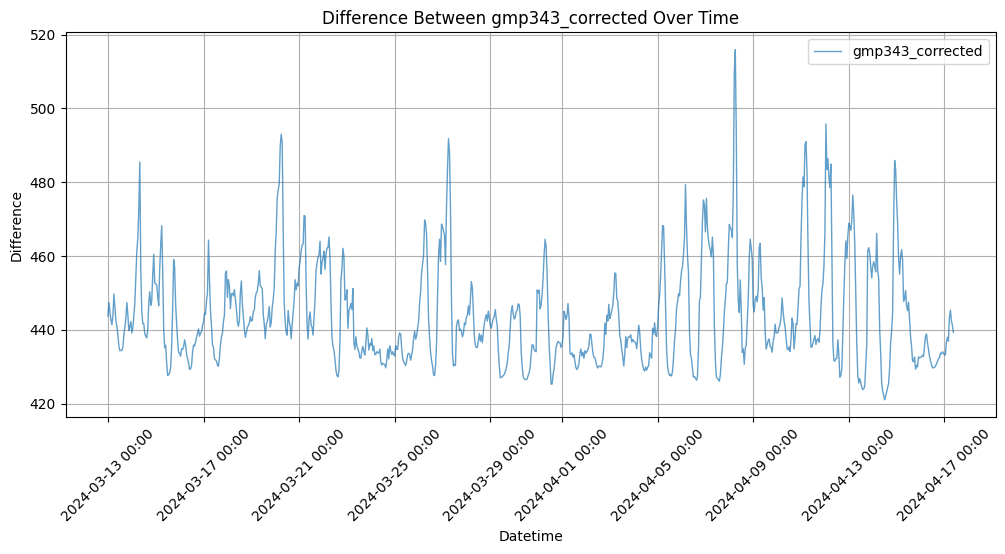

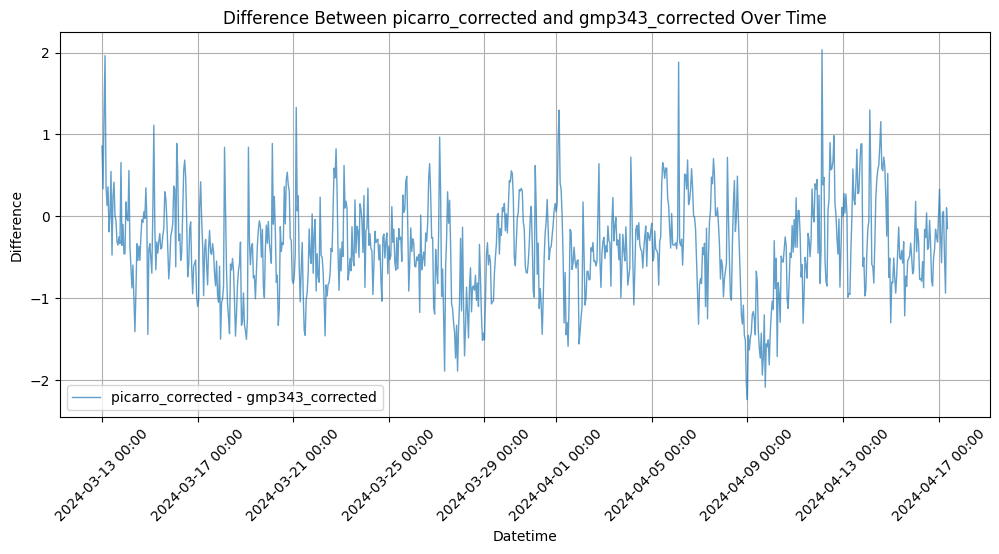

In [6]:
df_system = df.filter(pl.col("system_id") == 2)

plot_column(df=df_system, datetime_col="datetime", col1="gmp343_corrected", sample_size=100_000)
plot_column_difference(df=df_system, datetime_col="datetime", col1="picarro_corrected", col2="gmp343_corrected", sample_size=100_000)

In [7]:
def calculate_performance_metrics(df: pl.DataFrame, col:str = "gmp343_corrected") -> pl.DataFrame:
    return df.with_columns(diff = pl.col("picarro_corrected") - pl.col(col)) \
        .filter(pl.col("diff").is_not_nan()) \
        .select([
            (pl.col("diff").mean()).alias("mean_full_deployment"),
            (pl.col("diff").pow(2).mean()).alias("mse_full_deployment"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("rmse_full_deployment")
        ])

print(calculate_performance_metrics(df_system, col="gmp343_corrected"))

shape: (1, 3)
┌──────────────────────┬─────────────────────┬──────────────────────┐
│ mean_full_deployment ┆ mse_full_deployment ┆ rmse_full_deployment │
│ ---                  ┆ ---                 ┆ ---                  │
│ f64                  ┆ f64                 ┆ f64                  │
╞══════════════════════╪═════════════════════╪══════════════════════╡
│ -0.382564            ┆ 0.493064            ┆ 0.702185             │
└──────────────────────┴─────────────────────┴──────────────────────┘
